## Notes for ResNet-50 model:
A pre-trained model can help us solve problems like classifying brain tumor MRI images without starting from scratch.

Pre-trained models like VGG, Inception, and ResNet50 are trained on big datasets to solve problems similar to ours.

Training these models from scratch takes a lot of time and computer power for weeks or months. That's why we use these ready-made models from other research. They have already learned useful features that can help us.

For this brain tumor project, I chose the ResNet50 model. This model will help classify brain tumor MRI images efficiently. You can read more about ResNet50 in this article: 
https://doi.org/10.48550/arXiv.1512.03385

In [3]:
import cv2
import os
import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import imutils
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator

## Step 1a: Data Preprocessing

1. Clean image, remove black space, focus on brain only.

2. Use cv2 to process cleaned images.

In [5]:
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Apply thresholding, then erode and dilate to clean up small noise regions
    threshold_image = cv2.threshold(gray_image, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_image = cv2.erode(threshold_image, None, iterations=2)
    threshold_image = cv2.dilate(threshold_image, None, iterations=2)

    # Find contours and select the largest one
    contours = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    largest_contour = max(contours, key=cv2.contourArea)

    # Identify extreme points
    ext_left = tuple(largest_contour[largest_contour[:, :, 0].argmin()][0])
    ext_right = tuple(largest_contour[largest_contour[:, :, 0].argmax()][0])
    ext_top = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])
    ext_bottom = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    cropped_image = image[ext_top[1]-ADD_PIXELS:ext_bottom[1]+ADD_PIXELS, ext_left[0]-ADD_PIXELS:ext_right[0]+ADD_PIXELS].copy()
    
    return cropped_image

# Directories for training and testing datasets
training_directory = "dataset/Training"
testing_directory = "dataset/Testing"
training_folders = os.listdir(training_directory)
testing_folders = os.listdir(testing_directory)
IMAGE_SIZE = 256

# Process and save cleaned training images
for folder in training_folders:
    save_dir = 'cleaned/Training/' + folder
    folder_path = os.path.join(training_directory, folder)
    images_list = os.listdir(folder_path)
    for img_file in images_list:
        img = cv2.imread(os.path.join(folder_path, img_file))
        processed_img = preprocess_image(img)
        processed_img = cv2.resize(processed_img, (IMAGE_SIZE, IMAGE_SIZE))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        cv2.imwrite(save_dir + '/' + img_file, processed_img)

# Process and save cleaned testing images
for folder in testing_folders:
    save_dir = 'cleaned/Testing/' + folder
    folder_path = os.path.join(testing_directory, folder)
    images_list = os.listdir(folder_path)
    for img_file in images_list:
        img = cv2.imread(os.path.join(folder_path, img_file))
        processed_img = preprocess_image(img)
        processed_img = cv2.resize(processed_img, (IMAGE_SIZE, IMAGE_SIZE))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        cv2.imwrite(save_dir + '/' + img_file, processed_img)


## Step 1b: Data preprocessing
### Explanation

1. **Labels Definition**
   - `labels` list got different types of brain tumors.

2. **Initialization**
   - Four lists to keep training and testing images and labels.

3. **Image Size**
   - `image_size` set to 200x200 pixels.

4. **Loading and Preprocessing Images**
   - For each label, load images from `cleaned/Training` and `cleaned/Testing`.
   - Preprocess images by:
     - Load in grayscale.
     - Use bilateral filter to reduce noise.
     - Apply pseudocolor map.
     - Resize to correct size.

5. **Normalization**
   - Change lists to numpy arrays.
   - Normalize pixel values to range [0, 1] by divide by 255.

6. **Output Shapes**
   - Print shapes of training and testing datasets to check loading and preprocessing steps.


In [7]:
# List of labels for the different brain tumor types
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Initialize lists to hold training and testing images and labels
x_train = []  # Training images
y_train = []  # Training labels
x_test = []   # Testing images
y_test = []   # Testing labels

# Define the desired image size for resizing
image_size = 200

# Loop through each label to load and preprocess the images
for label in labels:
    # Load and preprocess training images
    trainPath = os.path.join('cleaned/Training', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)  # Load image in grayscale
        image = cv2.bilateralFilter(image, 2, 50, 50)  # Denoise the image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Apply pseudocolor
        image = cv2.resize(image, (image_size, image_size))  # Resize image to 200x200
        x_train.append(image)
        y_train.append(labels.index(label))  # Append the corresponding label index

    # Load and preprocess testing images
    testPath = os.path.join('cleaned/Testing', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)  # Load image in grayscale
        image = cv2.bilateralFilter(image, 2, 50, 50)  # Denoise the image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Apply pseudocolor
        image = cv2.resize(image, (image_size, image_size))  # Resize image to 200x200
        x_test.append(image)
        y_test.append(labels.index(label))  # Append the corresponding label index

# Convert lists to numpy arrays and normalize images to the range [0, 1]
x_train = np.array(x_train) / 255.0  # Normalize training images
x_test = np.array(x_test) / 255.0    # Normalize testing images

# Print the shapes of the training and testing datasets
print(x_train.shape)
print(x_test.shape)


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 2202.22it/s]


(384, 200, 200, 3)
(96, 200, 200, 3)


## Step 1c: Data preprocessing
### Explanation

1. **Selecting Sample Images**
   - Pick first 15 images from training set to show.

2. **Creating Subplots**
   - Make 3x5 subplots grid with `plt.subplots` to arrange images.

3. **Displaying Images**
   - Show each selected image in a subplot using loop.
   - Use `plt.tight_layout()` to make sure subplots arranged properly without overlap.

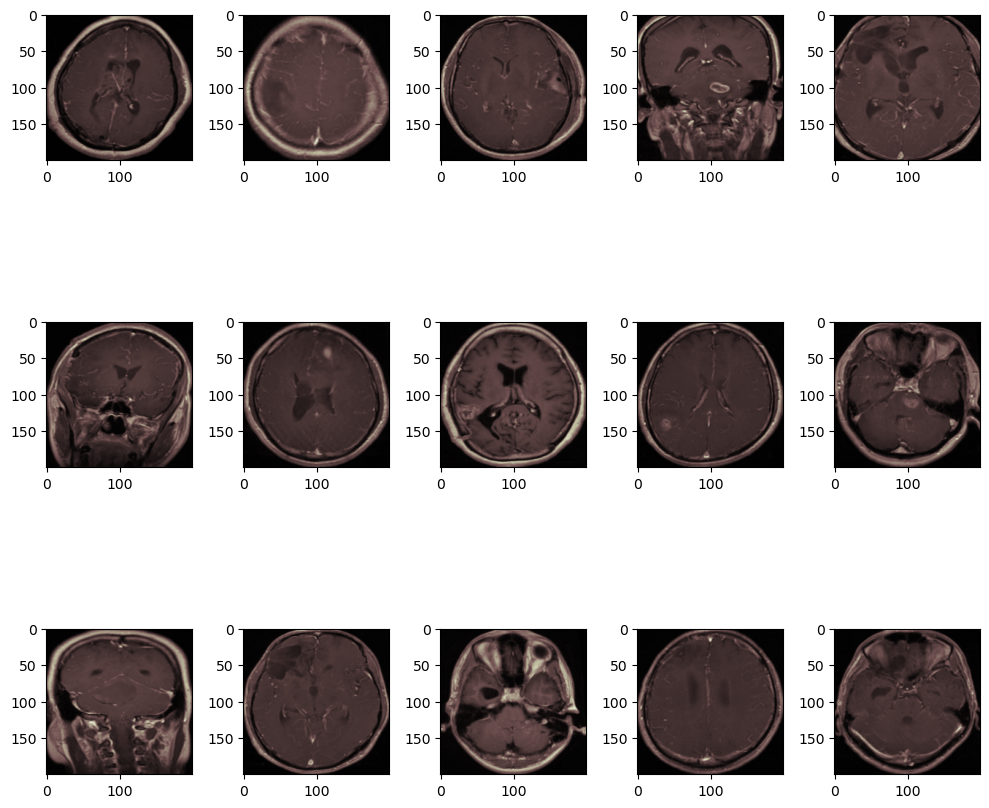

In [9]:
# Display some sample training images
# Select the first 15 images from the training dataset
images = [x_train[i] for i in range(15)]

# Create a grid of 3x5 subplots to display the images
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()

# Display each image in a subplot
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()


## Step 1d: Data preprocessing
### Further processing

1. **Shuffling Data**
   - Shuffle training images and labels to make sure model see different examples during training.

2. **One-Hot Encoding**
   - Change labels to one-hot encoded vectors for classification tasks.

3. **Train-Validation Split**
   - Train/validation split into 80/20 to check model performance on unseen data during training.

4. **Output Shape**
   - Print shape of validation dataset to check splitting process.

In [11]:
# Shuffle the training data
x_train, y_train = shuffle(x_train, y_train, random_state=42)

# One Hot Encoding on the labels
y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

# Splitting the dataset into Training and Validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_val.shape)

(77, 200, 200, 3)


## Step 2: Data Augmentation
To make use of our few training samples, we will **enhance** them using many random transformations. This make sure our model see different version of each image every time, which help to avoid **overfitting** and make model generalize better.

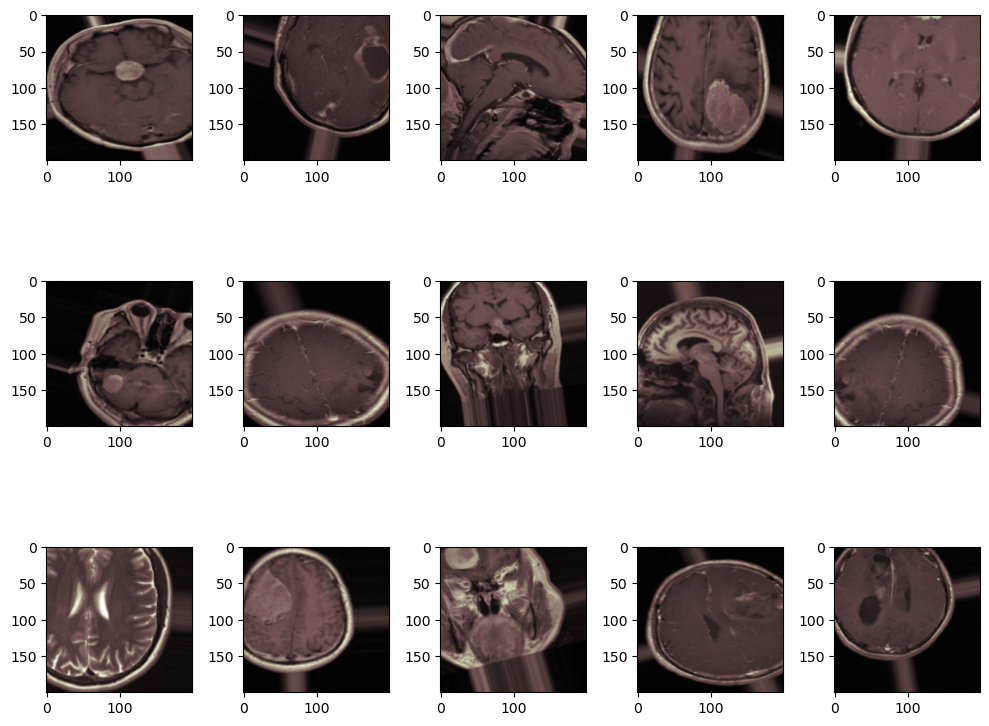

In [13]:
# Data Augmentation
# Apply random transformations to the training images to increase the diversity of the dataset
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training data
datagen.fit(x_train)

augmented_images = [datagen.flow(x_train, batch_size=1).next()[0] for _ in range(15)]
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()
for img, ax in zip(augmented_images, axes):
    ax.imshow(img)
    plt.tight_layout()

## Step 3: Model Selection, ResNet50
In this project, I use **ResNet50** model with weights from the **ImageNet** dataset.

**Note**

Setting `include_top` to `False` means all the layer weights are non-trainable. This is called "freezing" the layer: it won't change during training.

In [15]:
net = ResNet50(
    weights='imagenet', # load weights pre-trained on ImageNet.
     include_top=False, # exclude the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer works like Max Pooling but uses average values instead of max. This helps reduce the computational load during training.

**Dropout** -> This layer randomly ignores some neurons during each step to make them more independent. This helps prevent overfitting. The `rate` parameter decides the likelihood of a neuron being dropped.

**Dense** -> This is the output layer that classifies the image into one of the four classes, the result adds up to 1.0 which can be represented in terms of probability due to it's accumulation to 1.0.

In [17]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)  # increase dropout to avoid overfitting
model = Dense(4, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

# Compile model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Step 4: Training the Model
**callback** -> functions that run at different stages of training to check on the model.

**LambdaCallback** -> will log confusion matrix at every epoch.

**ModelCheckpoint** -> saves the model or weights at certain times.

**EarlyStopping** -> stops training if monitored metric stops improving.

**ReduceLROnPlateau** -> reduces learning rate when metric stops improving.

In [19]:
BATCH_SIZE = 4
EPOCHS = 100

# Define callbacks
Checkpoint = ModelCheckpoint(filepath='model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ES = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', restore_best_weights=True, verbose=1)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, mode='min')

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(x_val, y_val),
                    epochs=EPOCHS,
                    callbacks=[Checkpoint, ES, RL])


2024-07-11 18:47:53.654391: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
77/77 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.5733
Epoch 1: val_loss improved from inf to 2.28098, saving model to model-01-0.23-2.28.h5
77/77 [==============================] - 31s 374ms/step - loss: 1.0926 - accuracy: 0.5733 - val_loss: 2.2810 - val_accuracy: 0.2338 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7883
Epoch 2: val_loss did not improve from 2.28098
77/77 [==============================] - 34s 440ms/step - loss: 0.5503 - accuracy: 0.7883 - val_loss: 2.7048 - val_accuracy: 0.2338 - lr: 1.0000e-04
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.8143
Epoch 3: val_loss improved from 2.28098 to 1.67914, saving model to model-03-0.23-1.68.h5
77/77 [==============================] - 34s 446ms/step - loss: 0.4954 - accuracy: 0.8143 - val_loss: 1.6791 - val_accuracy: 0.2338 - lr: 1.0000e-04
Epoch 4/100
77/77 [==========================

## Learning curves

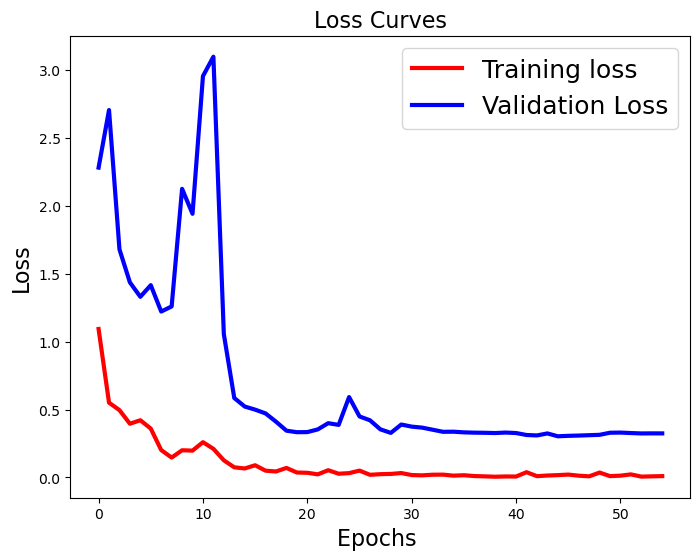

In [21]:
# Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

## Step 5: Evaluation the Model

3/3 [==============================] - 3s 950ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.92      0.92      0.92        24
           2       0.96      1.00      0.98        24
           3       1.00      0.96      0.98        24

    accuracy                           0.95        96
   macro avg       0.95      0.95      0.95        96
weighted avg       0.95      0.95      0.95        96



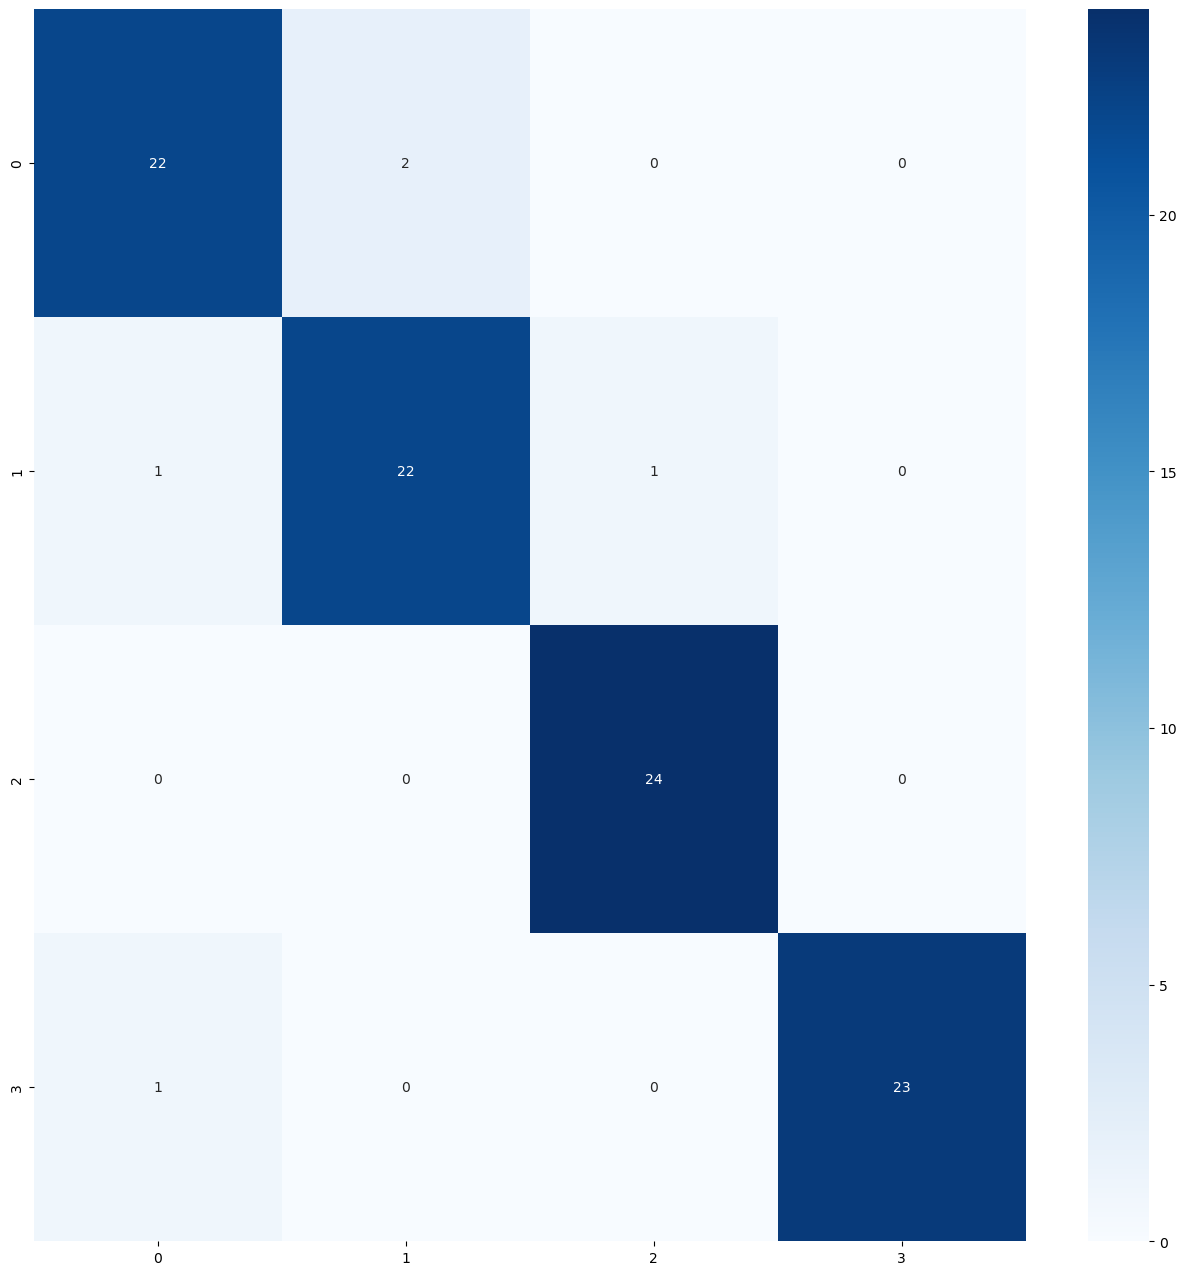

In [23]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [24]:
loss,acc = model.evaluate(x_test,y_test)

3/3 [==============================] - 3s 915ms/step - loss: 0.1865 - accuracy: 0.9479
